# <span style="color:green"> Laboratorio di simulazione numerica </span>

### Martina Colombo, 977556


## <span style="color:blue">  Esercitazione 6</span>

In [7]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from IPython.display import HTML

In [27]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

In [12]:
params = {'font.size':18, 'legend.fontsize': 'large' ,'axes.labelsize': 'x-large','axes.titlesize':'x-large','xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Esercizio 06.1

Lo scopo di questa esercitazione è quello di simulare il modello di Ising unidimensionale utilizzando due tipi di algoritmi di campionamento: Metropolis e Gibbs. Consideriamo un sistema di $50$ spin che viene inizializzato in maniera casuale con spin up $+1$ e spin down $-1$, scegliamo come termine di interazione $J=1$, scegliendo $J$ positivo abbiamo che il sistema tenderà ad allineare gli spin seguendo un modello di tipo ferromagnetico.

Utilizziamo il codice in C++ che ci viene fornito implementando nella funzione **Move** i due algoritmi di campionamento:

- **Metropolis**: per prima cosa selezioniamo casualmente uno spin in posizione $i$ valutiamo l'energia attuale associata allo spin $i$ tramite $H = -J \cdot  s_i \cdot (s_{i-1} + s_{i+1}) - h \cdot s_i$ utilizzando le condizioni periodiche al contorno, valutiamo la nuova energia data dal flipping dello spin scelto, calcoliamo la probabilità di accettazione tramite il peso di Boltzmann $A=min(1, \frac {e^{-\beta H_{new}}} {e^{-\beta H_{old}}})$, generiamo un numero casuale compreso tra $0$ e $1$, se questo è minore o uguale ad $A$ allora accettiamo la mossa e modifichiamo lo spin nella posizione $i$ con il rispettivo spin flippato, altrimenti manteniamo lo spin inalterato. 


- **Gibbs**: scegliamo anche in questo caso uno spin casuale $i$, valutiamo l'energia per uno spin up $H_{up} = -J \cdot  (+1) \cdot (s_{i-1} + s_{i+1}) - h \cdot (+1) $ e per uno spin down $H_{down} = -J \cdot  (-1) \cdot (s_{i-1} + s_{i+1}) - h \cdot (-1) $, calcoliamo ad esempio la probabilità associata all'energia $H_{up}$ come $ P_{up} = \frac{e^{-\beta H_{up}}} {e^{-\beta H_{up}}+e^{-\beta H_{down}}}$ generiamo un numero casuale compreso tra $0$ e $1$ con cui confrontare $P_{up}$, se questo numero è minore o uguale della probabilità di accettazione allora lo spin in posizione $i$ diventa uno spin up, altrimenti diventa uno spin down. 

Aggiungiamo inoltre la possibilità di far partire il sistema da una configurazione precedente tramite il metodo del restart in modo tale da equilibrare il sistema a una data temperatura prima di calcolare le medie delle grandezze di interesse. 

Ripetiamo l'algoritmo di campionamento per un numero $M=10^5$ di passi, applichiamo il metodo a blocchi per calcolare le medie delle grandezze legate al sistema tra cui:
- **Energia interna** (con campo magnetico esterno nullo $h=0$):  $U(N,T) = \langle H \rangle_{h=0}$
- **Capacità terminca** : $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
- **Magnetizzazione** : $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$
- **Suscettività magnetica**: $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$

Scegliamo un numero di blocchi $N=50$. 

Eseguiamo $12$ simulazioni (per il sistema equilibrato) con diversi valori della temperatura compresi tra $\left[0.5;2.0\right]$ e analizziamo come variano le grandezze di interesse elencate sopra al variare della temperatura $T$. Riportiamo di seguito i risultati ottenuti.

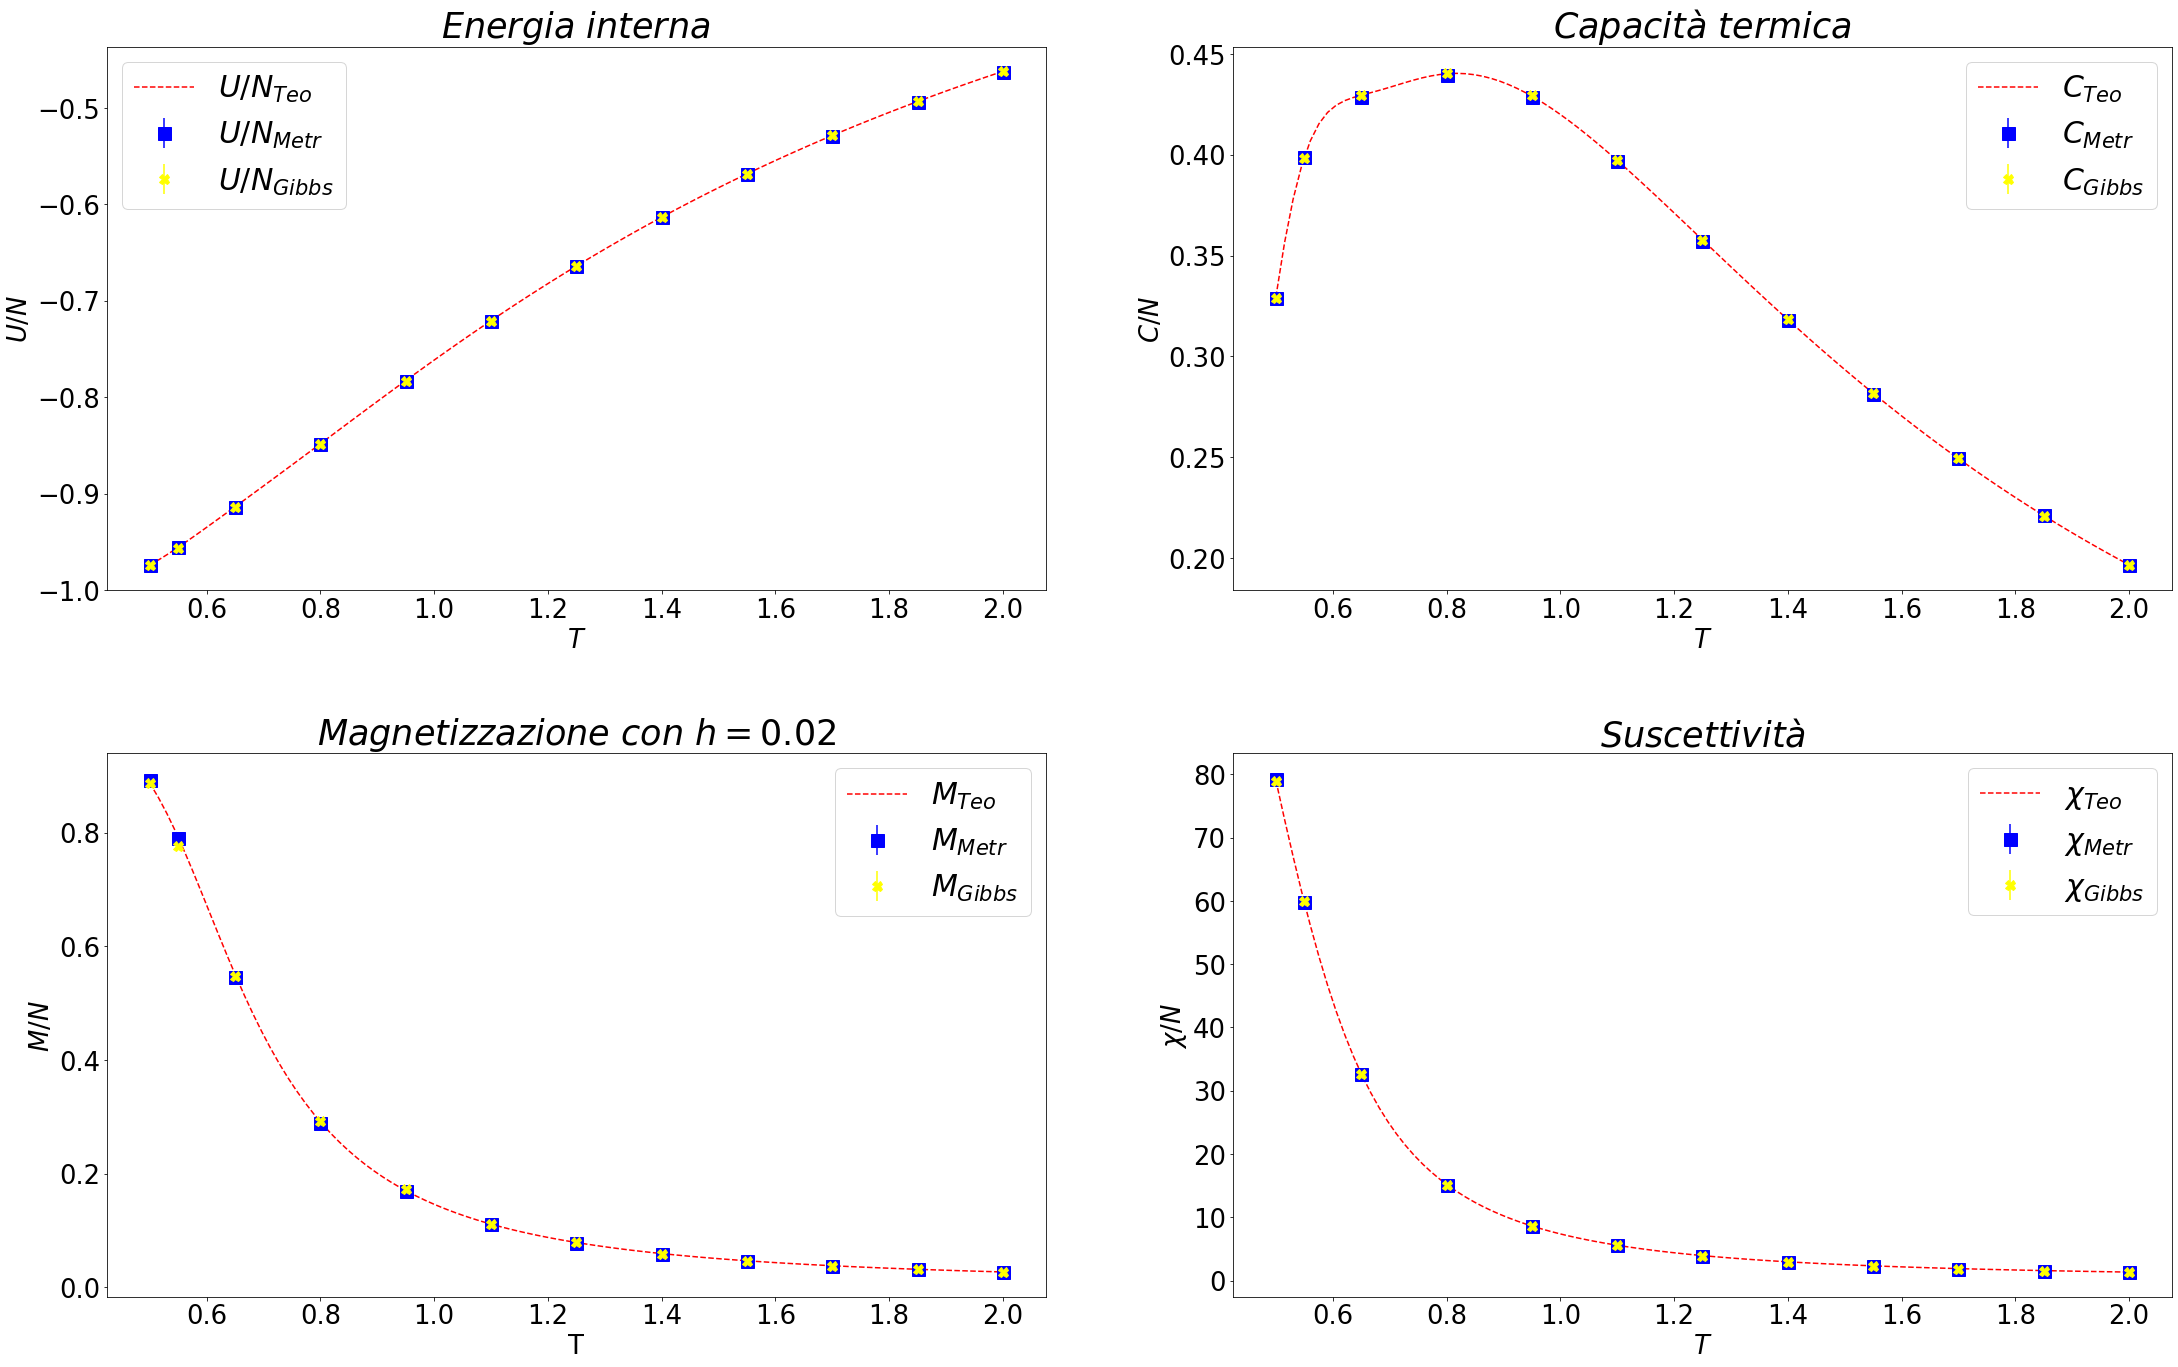

In [25]:
plt.figure(figsize=(37,23))

plt.subplot(2,2,1)
temp, ene, std = np.loadtxt("ISING_1D/ene_final.dat", usecols=(0,2,3), delimiter=' ', unpack='true')
plt.errorbar(temp,ene,yerr=std, label='$U/N_{Metr}$', fmt='s', c='blue', markersize='13')

temp_gibbs, ene_gibbs, std_gibbs = np.loadtxt("ISING_1D/ene_Gfinal.dat", usecols=(0,2,3), delimiter=' ', unpack='true')
plt.errorbar(temp_gibbs,ene_gibbs,yerr=std_gibbs, label='$U/N_{Gibbs}$', fmt='X', c='yellow', markersize='10')

points=100
T = np.linspace(0.5,2.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )
plt.plot(T, e, label='$U/N_{Teo}$', linestyle='dashed', c='r')
plt.title('$Energia$ $interna$', fontsize=35)
plt.xlabel('$T$')
plt.ylabel('$U/N$')
plt.legend(fontsize=30)


plt.subplot(2,2,2)

temp, c_heat, std = np.loadtxt("ISING_1D/heat_final.dat", usecols=(0,2,3), delimiter=' ', unpack='true')
plt.errorbar(temp,c_heat,yerr=std, label='$C_{Metr}$', fmt='s', c='blue', markersize='13')

temp_gibbs, heat_gibbs, std_gibbs = np.loadtxt("ISING_1D/heat_Gfinal.dat", usecols=(0,2,3), delimiter=' ', unpack='true')
plt.errorbar(temp_gibbs,heat_gibbs,yerr=std_gibbs, label='$C_{Gibbs}$', fmt='X', c='yellow', markersize='10')

heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
plt.plot(T, heat, label='$C_{Teo}$', linestyle='dashed', c='r')
plt.title('$Capacità$ $termica$', fontsize=35)
plt.xlabel('$T$')
plt.ylabel('$C/N$')
plt.legend(fontsize=30)


plt.subplot(2,2,3)

temp, magn, std = np.loadtxt("ISING_1D/magn_final.dat", usecols=(0,2,3), delimiter=' ', unpack='true')
plt.errorbar(temp,magn,yerr=std, label='$M_{Metr}$', fmt='s', c='blue', markersize='13')

temp_gibbs, magn_gibbs, std_gibbs = np.loadtxt("ISING_1D/magn_Gfinal.dat", usecols=(0,2,3), delimiter=' ', unpack='true')
plt.errorbar(temp_gibbs,magn_gibbs,yerr=std_gibbs, label='$M_{Gibbs}$', fmt='X', c='yellow', markersize='10')

h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
plt.plot(T, M, label='$M_{Teo}$', linestyle='dashed', c='r')
plt.title('$Magnetizzazione$ $con$ $h = 0.02$', fontsize=35)
plt.xlabel('T')
plt.ylabel('$M/N$')
plt.legend(fontsize=30) 

plt.subplot(2,2,4)

temp, chi, std = np.loadtxt("ISING_1D/chi_final.dat", usecols=(0,2,3), delimiter=' ', unpack='true')
plt.errorbar(temp,chi,yerr=std, label='$\chi_{Metr}$', fmt='s', c='blue', markersize='13')

temp_gibbs, chi_gibbs, std_gibbs = np.loadtxt("ISING_1D/chi_Gfinal.dat", usecols=(0,2,3), delimiter=' ', unpack='true')
plt.errorbar(temp_gibbs,chi_gibbs,yerr=std_gibbs, label='$\chi_{Gibbs}$', fmt='X', c='yellow', markersize='10')

X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
plt.plot(T, X, label='$\chi_{Teo}$', linestyle='dashed', c='r')
plt.title('$Suscettività$', fontsize=35)
plt.xlabel('$T$')
plt.ylabel('$\chi/N$')
plt.legend(fontsize=30)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()

Dai grafici vediamo che l'energia interna per spin cresce con l'aumentare della temperatura, la capacità termica cresce fino a raggiungere un picco ad un valore della temperatura pari a $0.8$ per poi decrescere, la magnetizzazione per spin a basse temperature è circa uno perché il sistema tende ad avere una configurazine ordinata dove gli spin sono allineati, all'aumentare della temperatura il sistema diventa più caotico e la magnetizzazione decresce, infine la suscettività magnetica descresce con l'aumentare della temperatura. 